# Homework Model-Based Statistical Learning

**Joris LIMONIER**

Your report must be a pdf, a jupyter notebook, or a R markdown.

In this Notebook, we will implement the EM algorithm and the KMeans algorithm, compare them and adapt to higher dimensional cases.

## I - Introduction

### Tasks

#### 1 - Implementing the EM

- Implement (from scratch) the EM for a GMM on the variables 2 and 4 of the wine data set. Cluster the data and compare your results with k-means.
- An R file called `useful_functions.R` (**renamed `utils.R`**) can be useful for EM. Apart from that, try not to use packages to implement EM.
- To assess the quality of the clustering, you may use the function classError and/or adjustedRandIndex from the Mclust package.

#### 2 - Model selection

- Try to find a relevant number of clusters using the three methods seen in class: AIC, BIC, and (cross-)validated likelihood.

#### 3 - Towards higher dimensional spaces

- Try to model more than just two variables of the same data set. Do you find the same clusters, the same number of clusters.

### Imports


In [69]:
library(pgmm)
library(mvtnorm)
library(mclust)
library(ggplot2)

source("utils.R")
# Import data


### Load & explore slightly the data


In [70]:
data(wine)


X <- as.matrix(wine[, c(2, 4)])
y <- wine[, 1]

cat("X has", nrow(X), "rows and", ncol(X), "cols:", paste(colnames(X), collapse = " and "))


X has 178 rows and 2 cols: Alcohol and Fixed Acidity

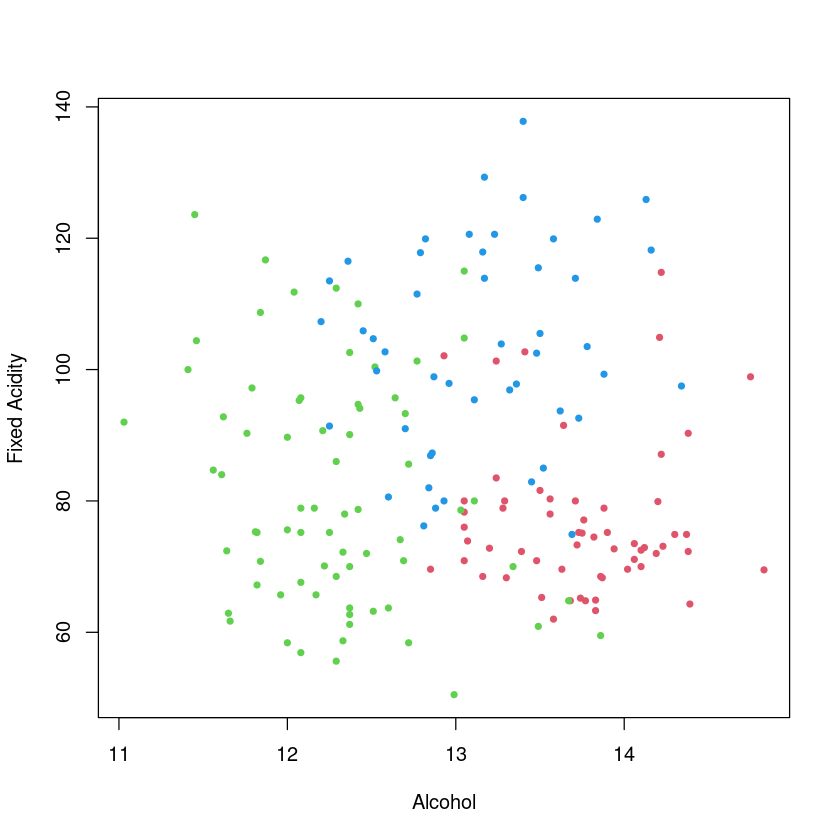

In [71]:
plot(X, col = y + 1, pch = 20)


### Train/test split

In order to evaluate the algorithm, we need to train it on some data and measure its performances on other, unseen, data.


In [72]:
# We use the indices to randomize the dataset
randomized_indexes <- sample(1:nrow(X))
randomized_X <- X[randomized_indexes, ]
randomized_y <- y[randomized_indexes]


n <- dim(X)[1]
training_split <- round(0.7 * n, 0)

X_train <- randomized_X[1:training_split, ]
X_test <- randomized_X[(training_split + 1):n, ]
y_train <- randomized_y[1:training_split]
y_test <- randomized_y[(training_split + 1):n]


## II - Declare functions

The following functions will be used through the whole document. They are clustered under different sections.

### Utility functions


In [73]:
euclidian_distance <- function(x, centroid) {
  # Compute the euclidian distance between a point and a centroid.

  # Declare intermediary functions for computing the euclidian distance
  dist <- function(a, b) (a - b)^2
  norm <- function(a) sqrt(sum(mapply(dist, a, centroid)))

  # Compute the distances
  distances <- t(apply(x, 1, norm))

  return(distances)
}

find_closest_centroids <- function(x, centroids, clusters) {
  # For each datapoint, compute the closest centroid

  # Initialize variables
  n <- dim(x)[1]
  distances <- c()

  # Compute euclidian distances
  for (cluster in 1:clusters) {
    cluster_dist <- euclidian_distance(x, centroids[cluster, ])
    distances <- append(distances, cluster_dist)
  }
  distances <- array(distances, dim = c(n, clusters))

  # Find closest centroid
  closest <- (distances == apply(distances, 1, min))

  return(list("distances" = distances, "closest" = closest))
}

find_clusters <- function(likelihoods) {
  # Given a 2D-array of likelihood values (likelihood of a point belonging to
  # a cluster), return the most likely cluster.

  clustering <- apply((likelihoods == apply(likelihoods, 1, max)), 1, which)

  return(clustering)
}

generate_centroid <- function(x) {
  # Generate random centroids from a multivariate normal distribution,
  # based on data mean and covariance

  # Variable initialization
  centroid <- c()

  # Randomly draws a value for each dimension of the dataset
  centroid <- rmvnorm(1, colMeans(x), cov(x))
  colnames(centroid) <- NULL

  return(centroid)
}

log_likelihood <- function(n, clusters, x, prop, mu, sigma) {
  # Compute the gamma values of a dataset as part of an EM algorithm.

  # Variable initialization
  lgn <- matrix(nrow = n, ncol = clusters)

  # Computes the gammas per clusters
  for (cluster in 1:clusters) {
    log_proba <- matrix(dmvnorm(x, mu[cluster, ], sigma[[cluster]], log = TRUE))
    lgn[, cluster] <- log(prop[cluster]) + log_proba
  }

  return(lgn)
}

log_sum_exp <- function(x) {
  # Compute the log-sum-exponential of a vector/list of variables.

  max(x) + log(sum(exp(x - max(x))))
}

most_matching_distribution <- function(clusters, x, prop, mu, sigma) {
  # Given a set of test points, find the best matching distributions.

  # Computes the likelihood of belonging to a distribution
  likelihoods <- log_likelihood(dim(x)[1], clusters, x, prop, mu, sigma)
  clustering <- find_clusters(likelihoods)

  return(list("likelihoods" = likelihoods, "clustering" = clustering))
}


#### KMeans


In [74]:
k_means <- function(x, clusters, max_iterations = 200, debug = T) {
  # Implementation of a K-Means algorithm.

  if (debug) {
    cat("Performing KM-Means with", clusters, "cluster(s).")
  }

  # Set variables for the dimension of data
  n <- dim(x)[1]
  K <- dim(x)[2]

  # Initialize variables
  centroids <- t(lapply(1:clusters, function(i) generate_centroid(x)))
  centroids <- matrix(unlist(centroids), ncol = K, byrow = TRUE)
  history_centroids <- c(centroids)

  # KM loop
  for (loop in 1:max_iterations) {

    # Compute the current closest centroids for each datapoint
    closest_centroids <- find_closest_centroids(x, centroids, clusters)

    # Update the closest centroids
    centroids <- c()
    for (cluster in 1:clusters) {
      # Check if ==2, to prevent colMeans crashes
      if (length(x[closest_centroids$closest[, cluster], ]) == 2) {
        column_means <- x[closest_centroids$closest[, cluster], ]
      } else {
        column_means <- colMeans(x[closest_centroids$closest[, cluster], ])
      }
      centroids <- rbind(centroids, column_means)
    }

    # Erase the matrix's columns and rows names coming from the dataset
    colnames(centroids) <- NULL
    rownames(centroids) <- NULL

    # Record the loop's update
    history_centroids <- append(history_centroids, centroids)
  }

  ret <- list(
    "centroids" = centroids,
    "distances" = closest_centroids$distances,
    "closest_centroids" = apply(closest_centroids$closest, 1, which),
    "centroids_history" = history_centroids
  )
  return(ret)
}


#### EM algorithm


In [75]:
expectation_maximization <- function(x, clusters, max_iterations = 200,
                                     km_init = F, debug = T) {
  # Implementation of an EM algorithm in high dimension.

  if (debug) {
    if (km_init) {
      cat("Performing EM with", clusters, "cluster(s), KM initialization.")
    } else {
      cat("Performing EM with", clusters, "cluster(s), random initialization.")
    }
  }

  # Set variables for dimensions of the input dataset
  n <- dim(x)[1]
  K <- dim(x)[2]

  # Initialize EM parameters. Use KMeans depending on parameter
  prop <- rep(1 / clusters, clusters)
  if (km_init) {
    mu <- k_means(x, clusters, max_iterations, debug = F)$centroids
  } else {
    mu <- rmvnorm(clusters, colMeans(x), cov(x))
  }
  sigma <- lapply(1:clusters, function(i) cov(x))

  # Initialize variables
  record_log_lik <- c()
  record_prop <- c()
  record_mu <- c()
  record_sigma <- c()
  previous_log_lik <- -Inf
  counter <- 0
  loop_counter <- 0

  # Start EM loop
  for (loop in 1:max_iterations) {

    # E-Step (with log-exp trick)
    loop_counter <- loop_counter + 1

    # Compute log-likelihood
    log_lik <- log_likelihood(n, clusters, x, prop, mu, sigma)
    sum_log_lik <- sum(apply(log_lik, 1, log_sum_exp))

    # Implement early stopping after 5 rounds without improvement
    if (round(sum_log_lik, 4) <= round(previous_log_lik, 4)) {
      counter <- counter + 1
      if (counter >= 5) {
        if (debug) {
          cat("\nEarly stopping at loop:", loop)
        }
        break
      }
    } else {
      counter <- 0
      previous_log_lik <- sum_log_lik
    }

    # Record the current log_lik to plot later
    record_log_lik <- append(record_log_lik, sum_log_lik)

    # Compute the gamma values per datapoints and clusters with the log-exp trick
    gam <- exp(log_lik - apply(log_lik, 1, log_sum_exp))

    # M-Step
    # Update the parameters
    for (cluster in 1:clusters) {

      # Compute the sum of gammas and updates the cluster's probabilities
      nk <- sum(gam[, cluster])
      prop[cluster] <- nk / n

      # Update the mean parameters
      mean_compute <- function(i) gam[i, cluster] * x[i, ]
      mu[cluster, ] <- Reduce("+", lapply(1:n, mean_compute)) / nk

      # Update the covariance matrix parameters
      m <- mu[cluster, ]
      sigma_compute <- function(i) gam[i, cluster] * (x[i, ] - m) %*% t(x[i, ] - m)
      sigma[[cluster]] <- Reduce("+", lapply(1:n, sigma_compute)) / nk
    }

    # Record parameter values
    record_prop <- append(record_prop, prop)
    record_mu <- append(record_mu, mu)
    record_sigma <- append(record_sigma, sigma)
  }

  # Compute the log-likelihood results on the given dataset
  log_lik_results <- most_matching_distribution(clusters, x, prop, mu, sigma)
  log_lik_sum <- sum(apply(log_lik_results$likelihoods, 1, log_sum_exp))
  if (debug) {
    cat("\nFinal log-likelihood: ", log_lik_sum)
  }

  # Formatting the record variables
  record_prop <- array(record_prop, c(loop_counter, clusters))
  record_mu <- array(record_mu, c(clusters, K, loop_counter))
  record_sigma <- array(record_sigma, c(clusters, K, K, loop_counter))

  ret <- list(
    "n" = n,
    "n_clusters" = clusters,
    "prop" = prop,
    "means" = mu,
    "sigma" = sigma,
    "clustering" = log_lik_results$clustering,
    "log_lik_of_points" = log_lik_results$likelihoods,
    "log_lik_sum" = log_lik_sum,
    "prop_history" = record_prop,
    "means_history" = record_mu,
    "sigma_history" = record_sigma,
    "log_lik_history" = record_log_lik
  )
  return(ret)
}


#### Akaike Information Criterion


In [76]:
akaike_ic <- function(ll, clusters, K) {
  # Computation of the the Akaike Information Criterion.
  # It is given by:
  # AIC = log-likelihood - eta(M)
  # That is :
  # - the final log-likelihood of a model
  # - minus the number of free scalar parameters in the model
  #   (nb of proportions - 1 for because there is one less degree of freedom)
  # - plus nb of means
  # - plus nb of sigmas
  ll - (clusters - 1) + clusters * K + clusters * ((K * (K + 1)) / 2)
}

compute_aic <- function(x, max_cluster = max_clusters, print_steps = TRUE) {
  #### Compute the AIC of an EM algorithm.

  # Initialize variable
  akaike_results <- c()

  # Loop through nb of clusters to compute the AIC
  for (cluster in min_clusters:max_cluster) {
    EM <- expectation_maximization(x, clusters = cluster, printMessage = F)
    akaike <- akaike_ic(EM$ll_sum, cluster, dim(x)[2])
    akaike_results <- append(akaike_results, akaike)
    if (print_steps) {
      print(paste("Total LL with ", cluster, " clusters: ", round(akaike, 3)))
    }
  }

  # Print the result
  print(paste(
    "The best AIC result is achieved with ",
    which.max(akaike_results) + 2,
    " clusters."
  ))
}


#### Bayesian Information Criterion


In [77]:
bayesian_ic <- function(ll, clusters, n, K) {
  # Computation of the Bayesian Information Criterion.
  # It is given by:
  # BIC = LL - 1/2*eta(M)*log(n)
  # That is:
  # - the final log-likelihood of a model
  # - minus half the number of free scalar parameters in the model
  #   (nb of proportions-1 as there is 1 less degree of freedom)
  # - plus nb of means + nb of sigmas
  # - times the log of the number of samples

  ll - ((clusters - 1) / 2 + clusters * K + clusters * ((K * (K + 1)) / 2)) * log(n)
}

compute_bic <- function(x, max_cluster = max_clusters, print_steps = TRUE) {
  # Computes the BIC of an EM algorithm.

  # Initialize variable
  bayesian_results <- c()

  # Loop through nb of clusters to compute the BIC
  for (cluster in min_clusters:max_cluster) {
    EM <- expectation_maximization(x, clusters = cluster, printMessage = F)
    bayesian <- bayesian_ic(EM$ll_sum, cluster, dim(x)[1], dim(x)[2])
    bayesian_results <- append(bayesian_results, bayesian)
    if (print_steps) {
      print(paste("Total LL with ", cluster, " clusters: ", round(bayesian, 3)))
    }
  }

  # Prints the result
  print(paste(
    "The best BIC result is achieved with ",
    which.max(bayesian_results) + 2,
    " clusters."
  ))
}


#### (Cross-)Validated Likelihood


In [78]:
double_cross_validation <- function(x_train, x_test, folds = 10, max_cl = max_clusters) {
  # Perform double cross-validation, using log-likelihood as the selection criterion.

  # Initialize variables
  n_train <- dim(x_train)[1]
  fold_allocation <- ceiling(seq_along(c(1:n_train)) / (n_train / 10))
  fold_indexes <- split(c(1:n_train), fold_allocation)
  mean_cluster_criteria <- c()

  # Iterate over cluster range
  for (cluster in min_clusters:max_cl) {

    lls <- c()
    best_model <- NULL

    # Iterate over the k-folds
    for (k_fold in fold_indexes) {

      # Set train and val datasets
      x_train_train <- x_train[-k_fold, ]
      x_train_val <- x_train[k_fold, ]

      # Compute EM on current training set
      EM <- expectation_maximization(x_train_train, cluster, printMessage = F)

      # Compute the LL's on the current validation set
      dists <- most_matching_distribution(
        EM$n_clusters, x_train_val, EM$prop, EM$means, EM$sigma
      )

      # Store the resulting LL
      sum_of_lls <- sum(apply(dists$likelihoods, 1, log_sum_exp))
      lls <- append(lls, sum_of_lls)

      # Update the best model if current is better
      if (is.null(best_model) || sum_of_lls == min(lls)) {
        best_model <- EM
      }
    }

    # Use best model on validation to compute likelihood on test set
    dists <- most_matching_distribution(
      best_model$n_clusters,
      x_test,
      best_model$prop,
      best_model$means,
      best_model$sigma
    )

    # Store log-likelihood
    lls <- append(lls, sum(apply(dists$likelihoods, 1, log_sum_exp)))

    # Store the mean LLs achieved with the current number of clusters
    print(paste(
      "Mean log-likelihood achieved with ", cluster, " clusters: ",
      round(mean(lls), 4)
    ))
    mean_cluster_criteria <- append(mean_cluster_criteria, mean(lls))
  }

  # Extract best performing number of clusters
  best_cluster <- which.max(mean_cluster_criteria)
  print(paste(
    "The best result is achieved with ",
    best_cluster + 2,
    " clusters (using double CV)."
  ))

  return(mean_cluster_criteria)
}


#### Plots

In [79]:
plot_data <- function(x, clustering, mean_clusters,
                      t = "K-Means", xl = "Alcohol", yl = "Fixed Acidity") {
  # Make a scatter plot with ellipses for clusters

  # Formats the input data as a dataframe
  df <- data.frame(x)
  mean_clusters <- data.frame(mean_clusters)
  names(mean_clusters) <- names(df)

  # Formats the clustering labels as factors for coloring
  colors <- as.factor(clustering)

  # Declares the plot
  p <- ggplot(df, aes_string(names(df)[1], names(df)[2], color = colors)) +
    geom_point() +
    stat_ellipse(geom = "polygon", aes(fill = colors), alpha = 0.05) +
    guides(fill = "none") +
    labs(
      color = "Wine Type",
      title = paste("Clustering obtained via", t),
      x = xl, y = yl
    ) +
    geom_point(data = mean_clusters, color = "black")

  return(p)
}


## Compare algorithms

In this section we compare the following algorithms:
- KMeans
- EM with random initialization
- EM with KMeans initialization

One choice of parameters is the number of clusters, but in this case we can *cheat* as we know that there are 3 clusters in the wine dataset. For this reason, we already set that choice right.

In [80]:
n_clusters <- 3
min_clusters <- length(unique(y))
max_clusters <- 10

#### KMeans with 3 clusters

Performing KM-Means with 3 cluster(s).

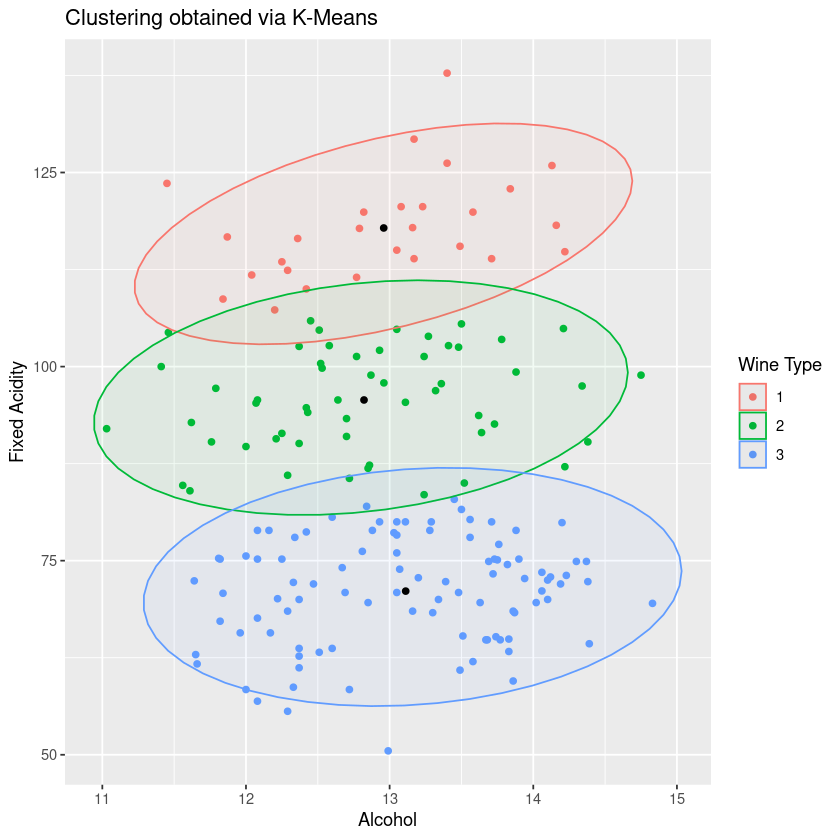

In [81]:
results_km <- k_means(X, n_clusters)

plot_data(X, results_km$closest_centroids, results_km$centroids)


#### EM (random initialization) with 3 clusters

Performing EM with 3 cluster(s), random initialization.
Early stopping at loop: 117
Final log-likelihood:  -949.7947

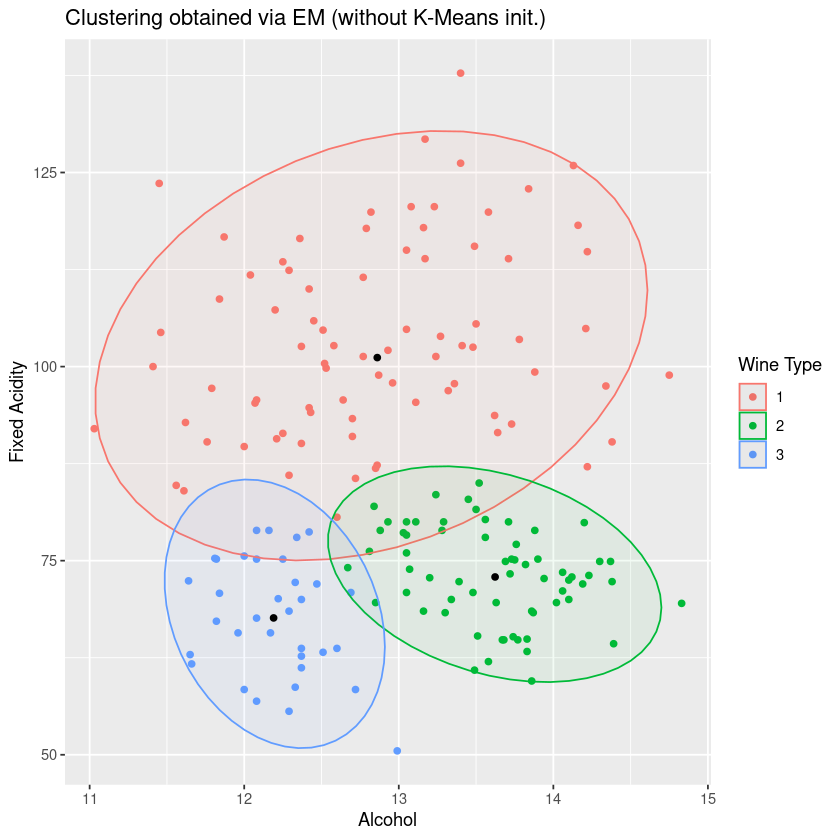

In [82]:
results_em_without_km <- expectation_maximization(X, n_clusters)

plot_data(X, results_em_without_km$clustering, results_em_without_km$means,
  t = "EM (without K-Means init.)"
)


#### EM (KMeans initialization) with 3 clusters

Performing EM with 3 cluster(s), KM initialization.
Final log-likelihood:  -963.3112

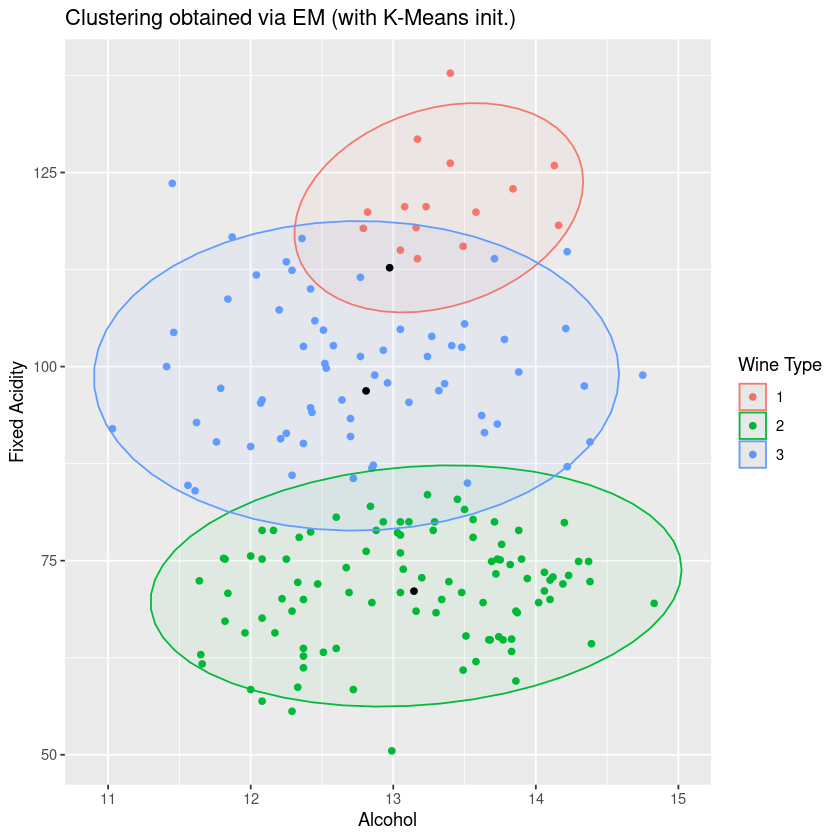

In [83]:
results_em_with_km <- expectation_maximization(X, n_clusters, km_init = T)

plot_data(X, results_em_with_km$clustering, results_em_with_km$means,
  t = "EM (with K-Means init.)"
)


#### Analysis

It seems that KMeans and EM with KMeans exhibit somewhat similar behaviors. One could say that the KMeans initialization influences the EM algorithm. As a result, the clusters look similar.

We cannot precisely say which algorithm performs better, but with respect to the shape of the clusters, it seems that the winner is EM with random initialization. However, we are now clustering the whole dataset. We need to perform a train-test split and see of each algorithm performs.

### Split the data

We now split the data into train and test sets before applying each algorithm respectively.

#### Train on train set

In [84]:
results_train_km <- k_means(X_train, n_clusters)

Performing KM-Means with 3 cluster(s).

In [85]:
results_train_em_without_km <- expectation_maximization(X_train, n_clusters)

Performing EM with 3 cluster(s), random initialization.
Early stopping at loop: 40
Final log-likelihood:  -664.8503

In [86]:
results_train_em_with_km <- expectation_maximization(X_train, n_clusters, km_init = T)

Performing EM with 3 cluster(s), KM initialization.
Early stopping at loop: 162
Final log-likelihood:  -666.7733

#### Evaluate on test set

In [87]:
# KM on test set
results_test_km <- find_closest_centroids(
  X_test,
  results_train_km$centroids,
  n_clusters
)
results_test_km$closest <- apply(results_test_km$closest, 1, which)

# EM (random) on test set
results_test_em_without_km <- most_matching_distribution(
  n_clusters,
  X_test,
  results_train_em_without_km$prop,
  results_train_em_without_km$means,
  results_train_em_without_km$sigma
)

# EM (KMeans) on test set
results_test_em_with_km <- most_matching_distribution(
  n_clusters,
  X_test,
  results_train_em_with_km$prop,
  results_train_em_with_km$means,
  results_train_em_with_km$sigma
)


#### Plot clustering on test set

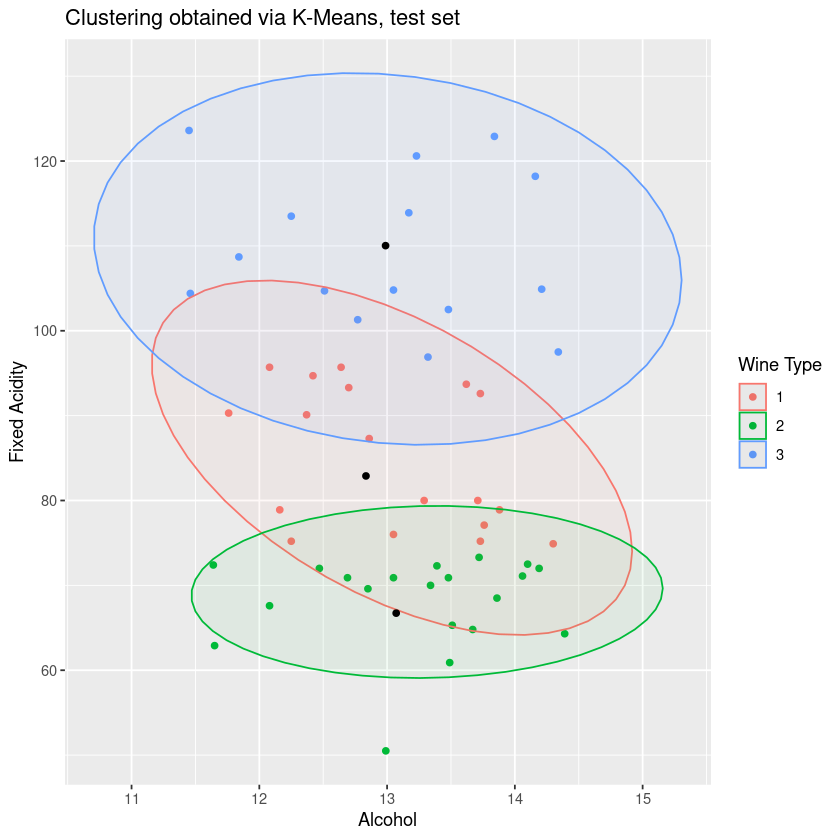

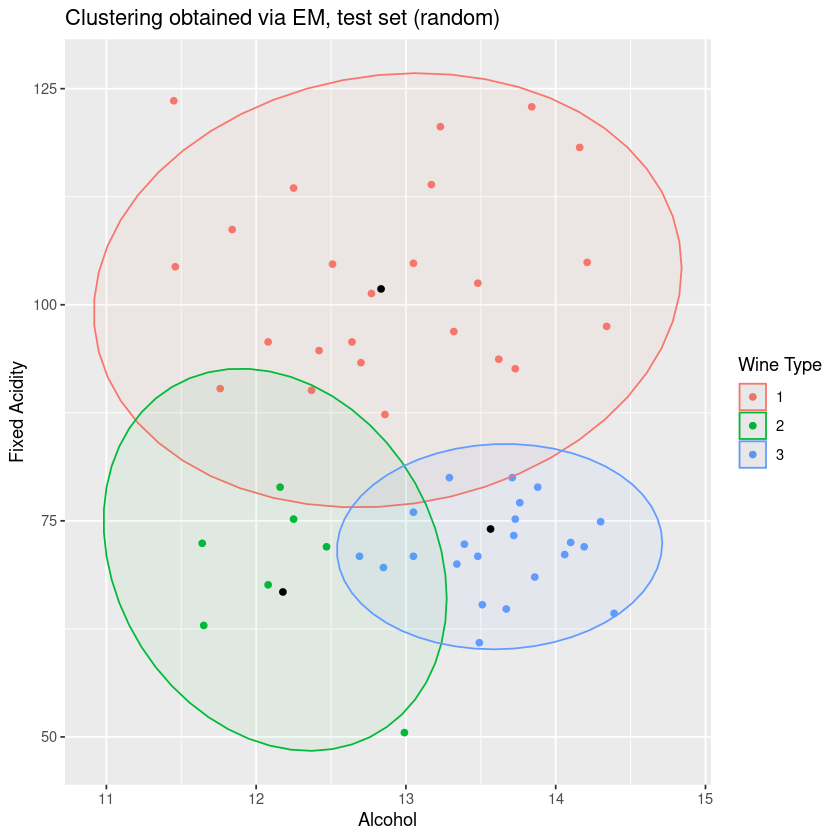

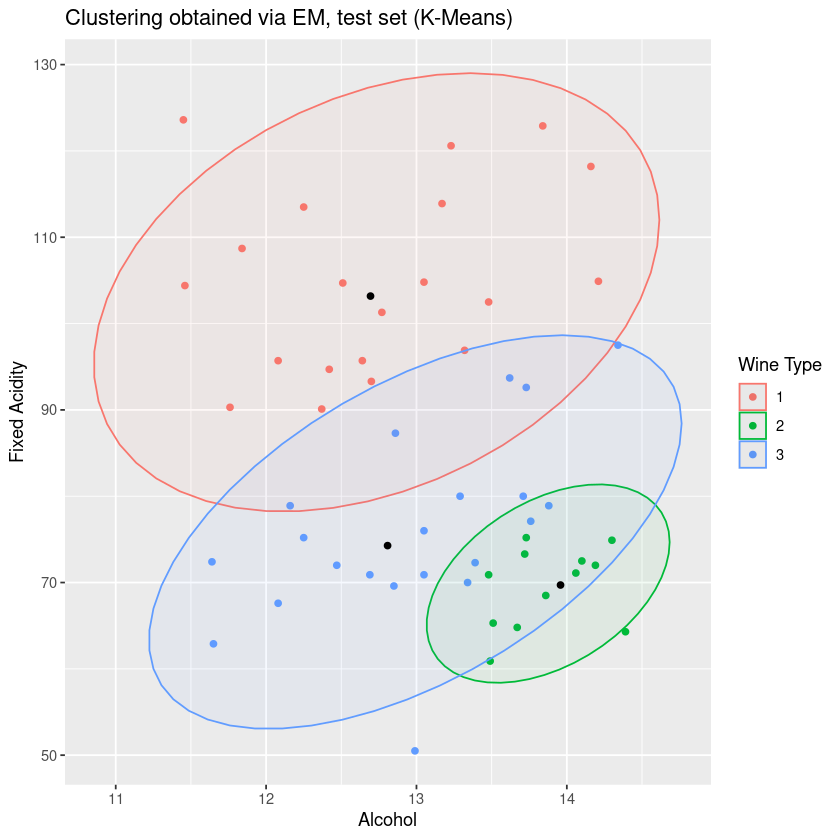

In [88]:
plot_data(X_test, results_test_km$closest, results_train_km$centroids,
  t = "K-Means, test set"
)

plot_data(X_test, results_test_em_without_km$clustering,
  results_train_em_without_km$means,
  t = "EM, test set (random)"
)
plot_data(X_test, results_test_em_with_km$clustering,
  results_train_em_with_km$means,
  t = "EM, test set (K-Means)"
)


#### Analysis

When splitting the data, we see that KMeans and the random EM still cluster very differently. The Kmeans EM however oscillates (depending on runs) between clusters that are sometimes similar to KMeans, sometimes to the random EM.

### Evaluate performance

#### Using class error on the whole dataset

We now evaluate the performance of each algorithm on the whole dataset. As suggested, we will use the `classError` function from the `mclust` library. It provides the missclasified samples indices, as well as the classification error rate. Both of these values should be as small as possible.


##### KMeans

In [89]:
classError(results_km$closest_centroid, y)

$misclassified
 [1]   5  14  20  22  40  42  44  46  47  57  61  63  64  65  66  67  68  69  71
[20]  72  73  74  75  76  77  78  79  81  82  83  85  86  87  88  89  90  91  92
[39]  93  96  97  98  99 100 101 102 103 104 105 106 107 109 117 121 123 124 125
[58] 130 131 132 133 134 135 136 137 138 140 141 142 143 144 147 148 149 151 153
[77] 155 158 159 160 162 163 164 165 166 167 176

$errorRate
[1] 0.488764

##### EM (random)

In [90]:
classError(results_em_without_km$clustering, y)

$misclassified
 [1]  14  20  22  40  42  44  46  47  57  60  62  63  67  69  70  72  73  77  78
[20]  80  84  86  94  95 100 108 110 111 112 113 114 115 116 118 119 120 121 122
[39] 123 124 125 126 127 128 129 130 132 133 140 141 143 162 167

$errorRate
[1] 0.2977528

##### EM (KMeans)

In [91]:
classError(results_em_with_km$clustering, y)


$misclassified
 [1]  14  20  22  40  42  44  46  47  57  61  63  64  65  66  67  68  69  71  72
[20]  73  74  75  76  77  79  81  82  83  85  86  87  88  89  90  91  92  93  96
[39]  97  98  99 101 102 103 104 105 106 107 109 117 124 131 132 133 134 135 136
[58] 137 138 140 141 142 143 144 145 147 148 149 151 153 155 158 159 160 161 162
[77] 163 164 165 166 167 171 172 174 176

$errorRate
[1] 0.4775281

#### Using class error on the test dataset
We do the same on the test dataset

##### KMeans

In [92]:
classError(results_test_km$closest, y_test)

$misclassified
 [1]  2  3  4  6 11 12 14 21 26 27 29 30 31 33 34 35 36 40 43 44 45 46 47 48 52

$errorRate
[1] 0.4716981

##### EM (random)

In [93]:
classError(results_test_em_without_km$clustering, y_test)

$misclassified
 [1]  2  8 11 15 17 19 27 30 33 35 38 44 45 46 47 51

$errorRate
[1] 0.3018868

##### EM (KMeans)

In [94]:
classError(results_test_em_with_km$clustering, y_test)

$misclassified
 [1]  1  3  4 11 12 13 14 20 21 24 27 29 31 33 34 36 40 41 42 43 45 46 48 52

$errorRate
[1] 0.4528302

#### Using adjusted rand index on the whole dataset
Now we follow the instruction suggestion to use the adjusted rand index, from the `mclust` library.

##### KMeans

In [95]:
adjustedRandIndex(results_km$closest_centroid, y)

[1] 0.1492959

##### EM (random)

In [96]:
adjustedRandIndex(results_em_without_km$clustering, y)

[1] 0.3285687

##### EM (KMeans)

In [97]:
adjustedRandIndex(results_em_with_km$clustering, y)


[1] 0.1598397

#### Using adjusted rand index on the test dataset

We do the same on the test dataset


##### KMeans

In [98]:
adjustedRandIndex(results_test_km$closest, y_test)

[1] 0.1204812

##### EM (random)

In [99]:
adjustedRandIndex(results_test_em_without_km$clustering, y_test)

[1] 0.3818236

##### EM (KMeans)

In [100]:
adjustedRandIndex(results_test_em_with_km$clustering, y_test)

[1] 0.131944

### Analysis

On a given run, we observed the following quantities, summarized in a table. Subsequent runs may produce different quantities.

| dataset | algorithm | init.  | class error | adjusted rand index |
| ------- | --------- | ------ | ----------- | ------------------- |
| full    | KMeans    | NA     | 0.49        | 0.15                |
| full    | EM        | random | 0.43        | 0.33                |
| full    | EM        | KMeans | 0.48        | 0.16                |
| test    | KMeans    | NA     | 0.47        | 0.12                |
| test    | EM        | random | **0.30**    | **0.38**            |
| test    | EM        | KMeans | 0.45        | 0.13                |

We notice that EM (both versions) tens to perform better than KMeans. We also note that in this case, random EM perform the best. This seems to generalize over runs, but due to the random nature of the algorithm, these results change from runs to others.

One should note that KMeans EM performing better than KMeans means that performing KMeans, then continuing the iterations with EM steps moves toward a better solution. This means that even after the total number of iterations made KMeans move towards a better solution, EM still manages to move further and end up in a better setting.

##### KMeans

##### EM (random)

##### EM (KMeans)